<a href="https://colab.research.google.com/github/AndreyMarks/AndreyMarks/blob/main/DFR_ANALISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar o cliente do BigQuery
!pip install --upgrade google-cloud-bigquery


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.36.0
    Uninstalling google-cloud-bigquery-3.36.0:
      Successfully uninstalled google-cloud-bigquery-3.36.0


In [1]:
from google.colab import auth
auth.authenticate_user()
print("Autenticado com sucesso!")


Autenticado com sucesso!


In [25]:

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

# Conectar ao BigQuery (autenticar se necessário)
project_id = "ed-cm-caranalytics-dev"
client = bigquery.Client(project=project_id)



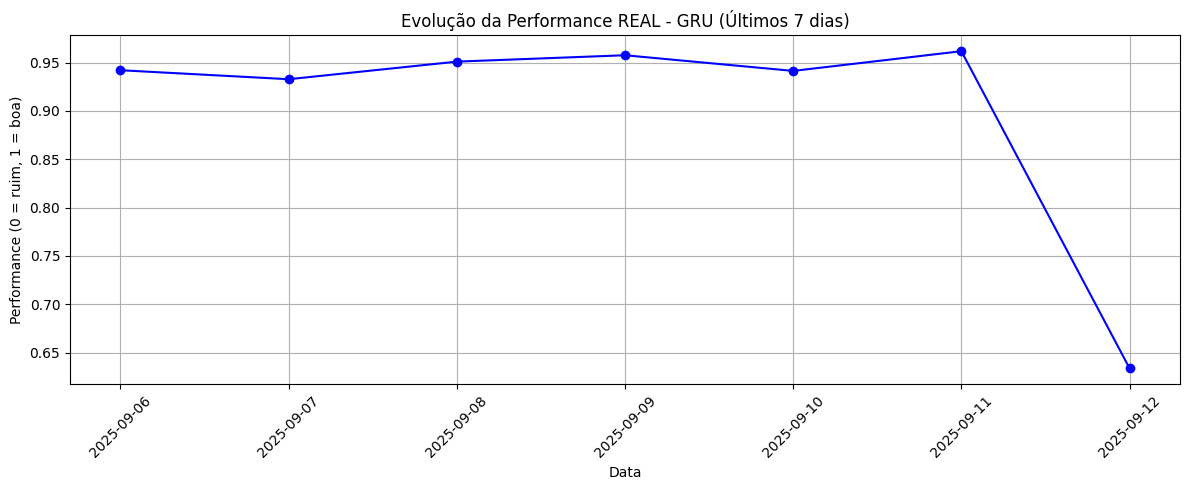

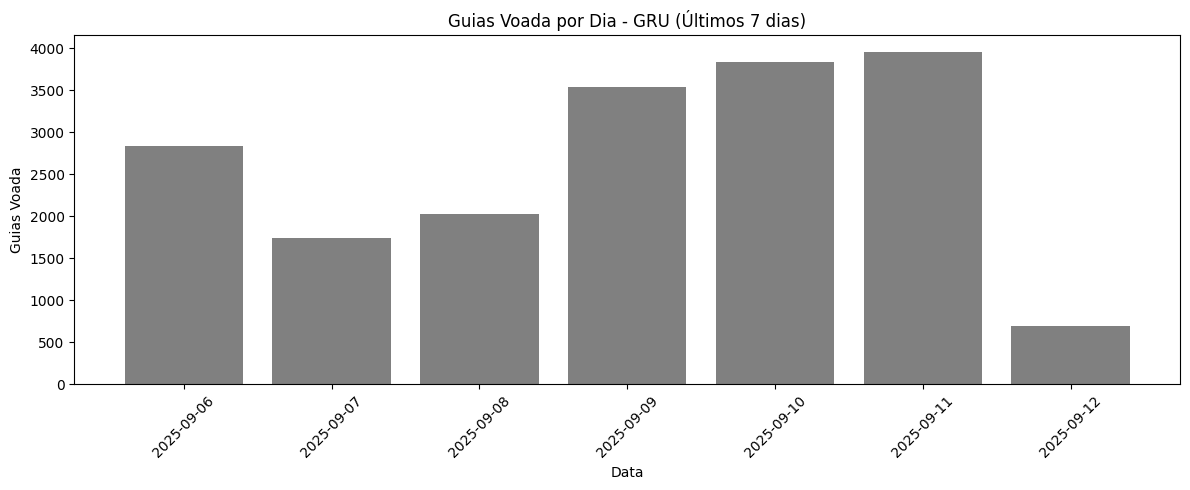

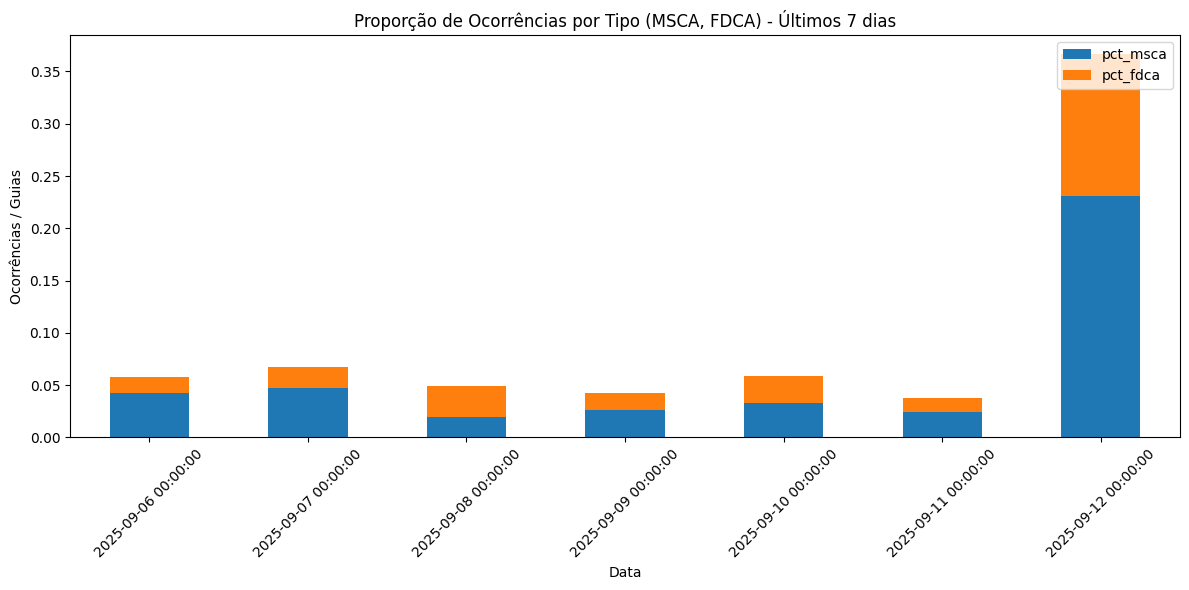

Número de dias com performance REAL crítica (< 0.85): 1

🚨 Top 3 dias com performance REAL crítica (< 0.85):


,flight_date_atd,performance_real
0,2025-09-12,0.6337


Soma total de DFR nos top 3 dias com pior performance: 252

✅ Top 3 dias com melhor performance REAL (> 0.85):


,flight_date_atd,performance_real
1,2025-09-11,0.9618
3,2025-09-09,0.9576
4,2025-09-08,0.9510


Soma total de DFR nos top 3 dias com melhor performance: 400


In [54]:


# Query SQL para últimos 7 dias no aeroporto GRU
query = """
SELECT
  flight_date_atd,
  airpt_origin_seg,
  guias_voadas,
  MSCA,
  FDCA,
  DFR,
  Performance
FROM
  `ed-cm-caranalytics-dev.QUALIDADE_OPS_BR.TB_DFR`
WHERE
  airpt_origin_seg = "GRU"
  AND flight_date_atd >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)
ORDER BY
  flight_date_atd DESC
"""

# Executa a consulta
query_job = client.query(query)
results = query_job.result()

# Converte para DataFrame
df = results.to_dataframe()

# Converte coluna de data para datetime
df["flight_date_atd"] = pd.to_datetime(df["flight_date_atd"])

# Calcula % de cada tipo de erro em relação às guias voadas, evitando divisão por zero
df["pct_msca"] = df["MSCA"] / df["guias_voadas"].replace(0, pd.NA)
df["pct_fdca"] = df["FDCA"] / df["guias_voadas"].replace(0, pd.NA)
df["pct_dfr"]  = df["DFR"]  / df["guias_voadas"].replace(0, pd.NA)

# Corrige performance (quanto maior, melhor)
df["performance_real"] = 1 - df["Performance"]

# ----------- VISUALIZAÇÕES -----------

# 1. Evolução da performance real
plt.figure(figsize=(12, 5))
plt.plot(df["flight_date_atd"], df["performance_real"], marker='o', color='blue')
plt.title("Evolução da Performance REAL - GRU (Últimos 7 dias)")
plt.xlabel("Data")
plt.ylabel("Performance (0 = ruim, 1 = boa)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# 2. Guias voadas por dia
plt.figure(figsize=(12, 5))
plt.bar(df["flight_date_atd"], df["guias_voadas"], color='gray')
plt.title("Guias Voada por Dia - GRU (Últimos 7 dias)")
plt.xlabel("Data")
plt.ylabel("Guias Voada")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Gráfico empilhado de erros relativos (MSCA, FDCA)
df_plot = df.set_index("flight_date_atd")[["pct_msca", "pct_fdca"]]
df_plot = df_plot.sort_index()
df_plot.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Proporção de Ocorrências por Tipo (MSCA, FDCA) - Últimos 7 dias")
plt.ylabel("Ocorrências / Guias")
plt.xlabel("Data")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



# ----------- ALERTAS DE PERFORMANCE -----------

# Alerta performance ruim (valor fixo)
limite_alerta = 0.85
df["alerta"] = df["performance_real"] < limite_alerta

df_criticos = df[df["alerta"] == True]

print(f"Número de dias com performance REAL crítica (< {limite_alerta}): {len(df_criticos)}")

# Top 3 dias com pior performance real
top_3_criticos = df_criticos.sort_values(by="performance_real").head(3)

print("\n🚨 Top 3 dias com performance REAL crítica (< 0.85):")
display(top_3_criticos[["flight_date_atd", "performance_real"]])

# Soma total de DFR nos top 3 dias críticos
soma_dfr_top3_criticos = top_3_criticos["DFR"].sum()
print(f"Soma total de DFR nos top 3 dias com pior performance: {soma_dfr_top3_criticos}")

# Alerta performance boa (acima do limite)
df_boa = df[df["performance_real"] > limite_alerta]
top_3_boa = df_boa.sort_values(by="performance_real", ascending=False).head(3)

print("\n✅ Top 3 dias com melhor performance REAL (> 0.85):")
display(top_3_boa[["flight_date_atd", "performance_real"]])

# Soma total de DFR nos top 3 dias bons
soma_dfr_boa = top_3_boa["DFR"].sum()
print(f"Soma total de DFR nos top 3 dias com melhor performance: {soma_dfr_boa}")


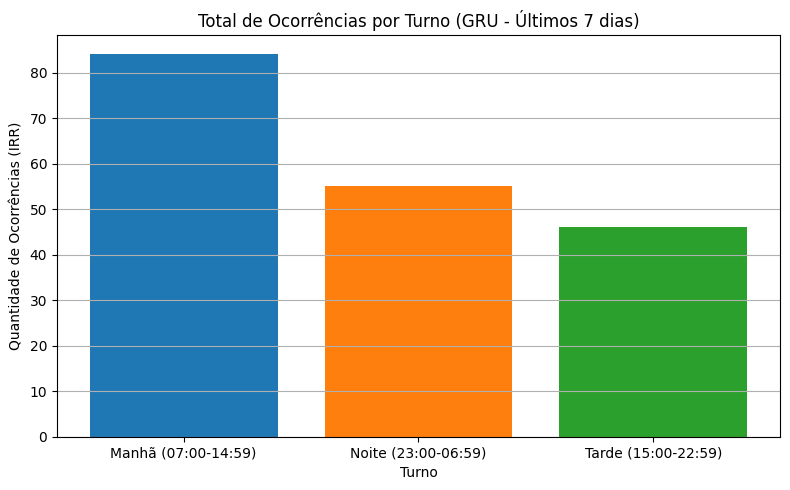

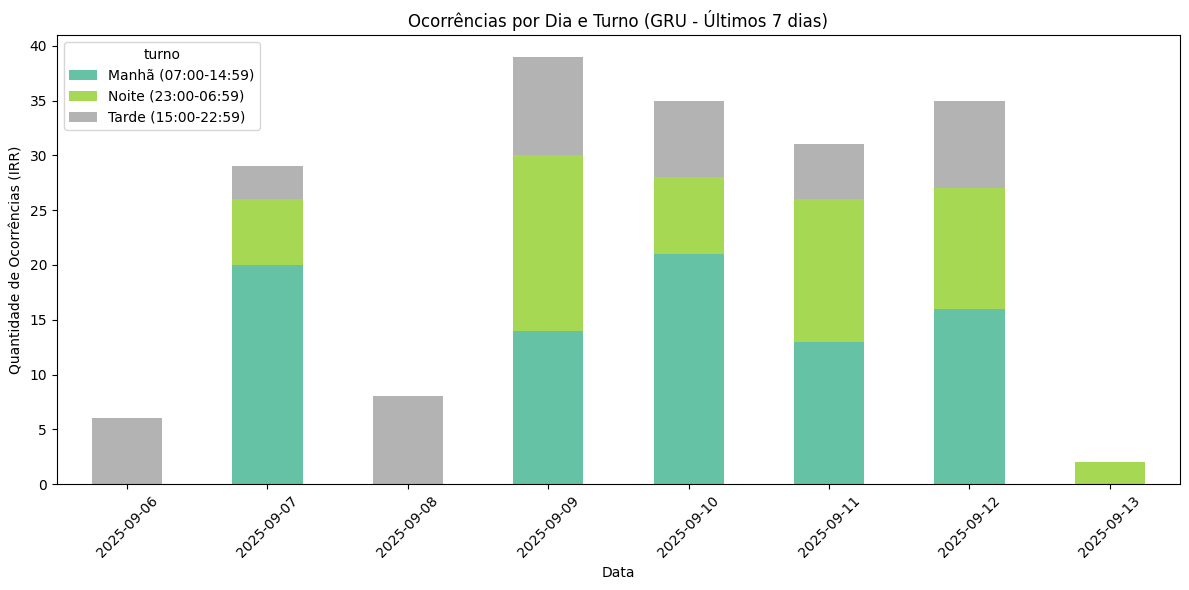

In [57]:
query = """
SELECT
  DATE(irr_date) AS data_irr,
  EXTRACT(HOUR FROM irr_date) AS hora,
  CASE
    WHEN EXTRACT(HOUR FROM irr_date) BETWEEN 7 AND 14 THEN 'Manhã (07:00-14:59)'
    WHEN EXTRACT(HOUR FROM irr_date) BETWEEN 15 AND 22 THEN 'Tarde (15:00-22:59)'
    ELSE 'Noite (23:00-06:59)'
  END AS turno,
  COUNT(*) AS qtd_irr
FROM
  `ed-cm-caranalytics-dev.QUALIDADE_OPS_BR.SC_DFR`
WHERE
  airpt_irr = 'GRU'
 AND irr_date >= DATETIME_SUB(DATETIME(CURRENT_TIMESTAMP()), INTERVAL 7 DAY)
GROUP BY
  data_irr,
  hora,
  turno
ORDER BY
  data_irr ASC, hora
"""

# Executar consulta
query_job = client.query(query)
df = query_job.result().to_dataframe()

# Agrupar total por turno
df_turnos = df.groupby("turno")["qtd_irr"].sum().reset_index().sort_values(by="qtd_irr", ascending=False)

# Plotar gráfico de barras
plt.figure(figsize=(8,5))
plt.bar(df_turnos["turno"], df_turnos["qtd_irr"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title("Total de Ocorrências por Turno (GRU - Últimos 7 dias)")
plt.xlabel("Turno")
plt.ylabel("Quantidade de Ocorrências (IRR)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Pivot para ver por dia e turno
df_pivot = df.pivot_table(index="data_irr", columns="turno", values="qtd_irr", aggfunc="sum").fillna(0)

# Plotar gráfico empilhado
df_pivot.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Set2")
plt.title("Ocorrências por Dia e Turno (GRU - Últimos 7 dias)")
plt.ylabel("Quantidade de Ocorrências (IRR)")
plt.xlabel("Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [58]:
query_irr_turnos = """
SELECT
  CASE
    WHEN EXTRACT(HOUR FROM irr_date) BETWEEN 7 AND 14 THEN 'Manhã'
    WHEN EXTRACT(HOUR FROM irr_date) BETWEEN 15 AND 22 THEN 'Tarde'
    ELSE 'Noite'
  END AS turno,
  COUNT(*) AS qtd_irr
FROM
  `ed-cm-caranalytics-dev.QUALIDADE_OPS_BR.SC_DFR`
WHERE
  airpt_irr = 'GRU'
  AND irr_date >= DATETIME_SUB(DATETIME(CURRENT_TIMESTAMP()), INTERVAL 7 DAY)
GROUP BY turno
"""

df_turnos_irr = client.query(query_irr_turnos).result().to_dataframe()


In [59]:
query_guias = """
SELECT
  flight_date_atd,
  guias_voadas
FROM
  `ed-cm-caranalytics-dev.QUALIDADE_OPS_BR.TB_DFR`
WHERE
  airpt_origin_seg = 'GRU'
  AND flight_date_atd >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)
"""

df_guias = client.query(query_guias).result().to_dataframe()


In [61]:
# Calcular a média de guias por dia
media_guias_dia = df_guias["guias_voadas"].mean()

# Total estimado de guias nos 7 dias
total_guias_7d = media_guias_dia * 7

# Adiciona coluna com proporção
df_turnos_irr["irr_por_guia"] = df_turnos_irr["qtd_irr"] / total_guias_7d
df_turnos_irr = df_turnos_irr.sort_values(by="irr_por_guia", ascending=False)


1. Gráfico de Proporção de Ocorrências por Guia Voada

📊 "Quantas falhas aconteceram em **média** por guia movimentada em cada turno?"

O que mede:
A eficiência relativa dos turnos — ou seja, se um turno tem mais falhas em relação ao volume de trabalho (guias).

O que revela:
Se um turno está mais suscetível a erro, mesmo com menos volume.

Exemplo de conclusão:

O turno da noite teve menos guias movimentadas, mas proporcionalmente mais erros.
Pode indicar falhas de processo, equipe reduzida etc.

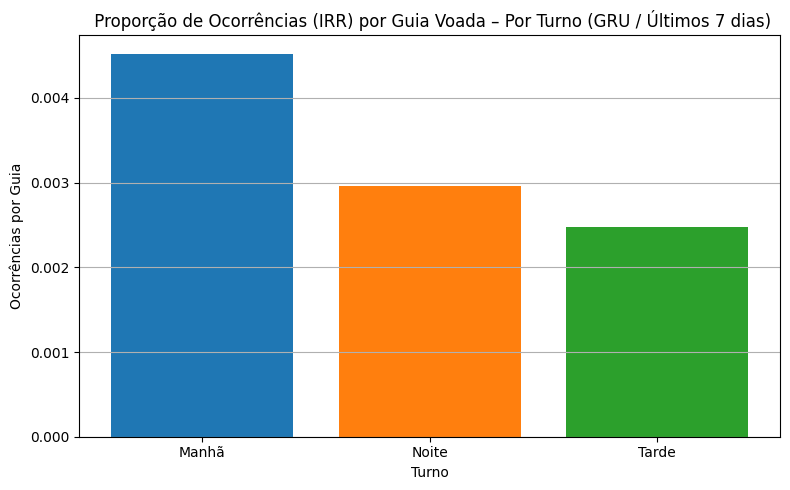

In [64]:
plt.figure(figsize=(8,5))
plt.bar(df_turnos_irr["turno"], df_turnos_irr["irr_por_guia"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title(" Proporção de Ocorrências (IRR) por Guia Voada – Por Turno (GRU / Últimos 7 dias)")
plt.xlabel("Turno")
plt.ylabel("Ocorrências por Guia")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


2. Gráfico de Total Bruto de Ocorrências por Turno

📈 "Qual turno teve o maior número de falhas **absolutas**?"

O que mede:
O volume total de ocorrências em cada turno, independente do volume de guias.

O que revela:
Onde há mais impacto bruto — importante para alocação de recursos e priorização.


Exemplo de conclusão:

O turno da manhã tem o maior número de falhas porque processa o maior volume de guias.
Talvez precise de mais pessoas ou processos otimizados.

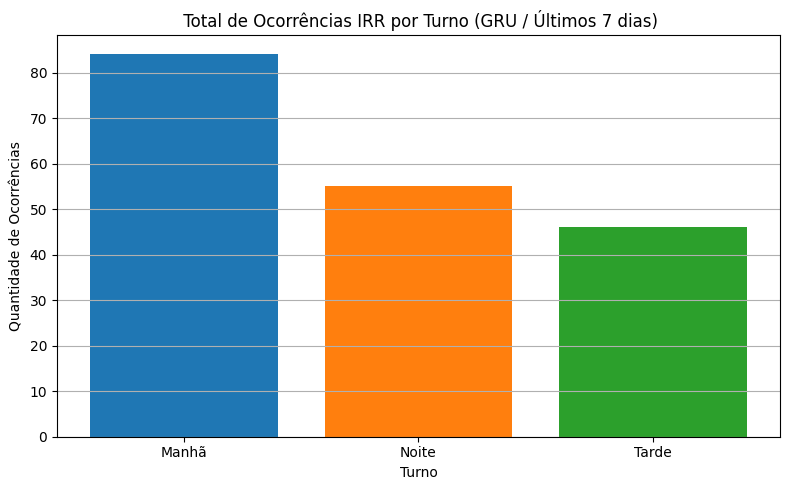

In [65]:
plt.figure(figsize=(8,5))
plt.bar(df_turnos_irr["turno"], df_turnos_irr["qtd_irr"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title(" Total de Ocorrências IRR por Turno (GRU / Últimos 7 dias)")
plt.xlabel("Turno")
plt.ylabel("Quantidade de Ocorrências")
plt.grid(axis="y")
plt.tight_layout()
plt.show()
